# Automatic (derivatives) for the people and a song of ice and fire

In [229]:
import matplotlib.pyplot as plt
import numpy as np
import math


### Exercise 1

#### Part 1

We import sys and get float info

In [230]:
import sys
print(sys.float_info)

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


Max is the largest representable number in computers, similarily min is the smallest representable number in computers.  
Epsilon tells us the smallest number we can add to one to get something other than one, the machine precision.

Most modern computers work on a finite 64-bit format and processes 64 bits at a time. The values given from `sys.float_info` come from the IEEE 754 standard**REFERENCE**. In this exercise we will focus on IEEE 754 double precision (64-bit) floating-point number.

From the 64 bits we have IEEE reserves one sign bit, 11 exponent bits and 52 fraction(mantissa) bits. There is also a "hidden bit" and implies the float always starts with "1.". To also represent numbers that have absoloute value less than one a number *bias* is added to the exponent. Bias is a fixed number and in 64 bits it is roughly half the exponent; $2^{11-1}-1 = 1023$. With this we can make a formula: 

\begin{equation}
±q2^{E-e}\tag{1}
\end{equation}

where ± is the sign bit, q the mantissa, E the exponent and $e$ the bias. E can have values from 0 to $2^{11} - 1$ = 2047. There are two special numbers to represent zero and infinity which are respectively $E = 0$, and $E = 2047$. With bias this gives us the largest possible exponent $2046 - 1023 = 1023$ and smallest exponent $1 - 1023 = -1022$  

To get the max value the exponent needs to be 1023, and the fraction needs be all ones and exponent the largest:

\begin{equation}
1.111 + (49\ more\ ones) \times 2^{1023} = (2^0 + 2^{-1} + 2^{-2} + ... + 2^{-52}) \times 2^{1023} = (2 - 2^{-52}) \times 2^{1023} = 1.7976931348623157 \times 10^{308}\tag{2}
\end{equation}

To get min we set the mantissa to all zeroes and use the lowest exponent:

\begin{equation}
1.000 + (49\ more\ zeroes) \times 2^{-1022} = 2^0 \times 2^{-1022} = 2.2250738585072014 \times 10^{-308}\tag{3}
\end{equation}

To find machine epsilon we use the smallest mantissa possible, which is all zeroes except the last bit; $2^{-52} \times 2^{0} = 2.220446049250313 \times 10^{-16}$. We cannot use an exponent less than zero because if we add that number to 1, it will still be 1.  

It is possible to represent smaller numbers by using unnormalized values.

#### Part 2  

The following code shows examples of floating-point arithmetic

In [231]:
print(0.1 + 0.2, 0.1 + 0.2 == 0.3)
print(0.125 + 0.25, 0.125 + 0.25 == 0.375)

0.30000000000000004 False
0.375 True


Seeing as computers store numbers in base-2 format the numbers 0.1, 0.2 and 0.3 cannot be accurately represented in binary, and results in precision error. The numbers 0.125, 0.25 and 0.375 can be represented in binary. We can see what these numbers actually looks like:

In [232]:
print(f"{0.1:.60f}")
print(f"{0.2:.60f}")
print(f"{0.3:.60f}\n")

print(f"{0.125:.60f}")
print(f"{0.25:.60f}")
print(f"{0.375:.60f}")

0.100000000000000005551115123125782702118158340454101562500000
0.200000000000000011102230246251565404236316680908203125000000
0.299999999999999988897769753748434595763683319091796875000000

0.125000000000000000000000000000000000000000000000000000000000
0.250000000000000000000000000000000000000000000000000000000000
0.375000000000000000000000000000000000000000000000000000000000


In the decimal system we have something similar with for example $1/3$ with repeating decimals (0.333...). Since computers work with finite bits it needs to cutoff at a point. This point is set in the mantissa and is at 52 bits.  

Numbers like 0.375 can be represented perfectly in binary as $2^{-2} + 2^{-3}$:

\begin{equation}
0.375_{10} = 0 \times 2^{-1} + 1 \times 2^{-2} + 1 \times 2^{-3} = 0.011_2\tag{4}
\end{equation}

Other numbers that can be represented perfectly in binary are $2^{-1}$ + $2^{-4}$:

In [233]:
print(0.5 + 0.0625)

0.5625


Another example that gives precision error is given:

In [234]:
print(f"{0.6 + 0.7:.60f}")
print(0.6 + 0.7 == 0.13)

1.299999999999999822364316059974953532218933105468750000000000
False


#### Part 3  

In the previous part we used the ==-operator to compare to floating-point numbers and check if they are equal. Because of these roundoff errors a direct comparison might not give the result we want. We can instead check the difference between the float a and b, and compare that value to check if they are close enough using defined epsilon as tolerance. We can use the formula: 

\begin{equation}
|1 - b/a| < \epsilon\tag{5}
\end{equation}

where epsilon is the tolerance. We test this formula by comparing two floats:

In [235]:
a = 0.1 + 0.2
b = 0.1
epsilon = 1e-9

print("Should return False:", abs(1 - b/a) < epsilon)

a = 0.1 + 0.2
b = 0.3
epsilon = 1e-9

print("Should return True:", abs(1 - b/a) < epsilon)

Should return False: False
Should return True: True


### Exercise 3

#### Part 1

Plotting the following function for describing wave phenomenona using matplotlib:

\begin{equation}
f(x) = cos(bx) \times e^{-ax^{2}}\tag{6}
\end{equation}

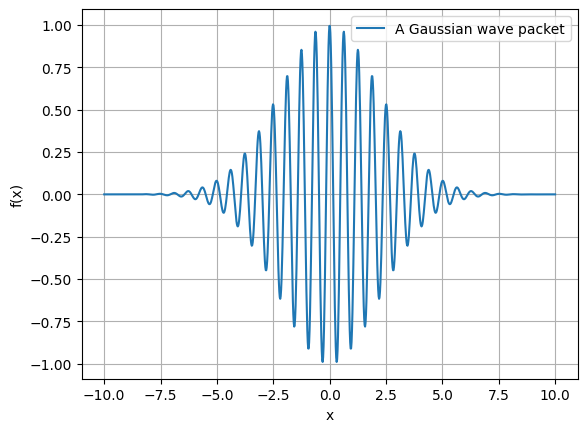

In [236]:
import matplotlib.pyplot as plt
def f(x, a=0.1, b=10):
    return np.cos(b*x)*np.exp(-a*x*x)

x = np.linspace(-10, 10, 1000)
y = f(x)

plt.plot(x,y, label="A Gaussian wave packet")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.legend()
plt.show()

#### Part 2  

Implementing the analytical derivative of f(x) in code:

In [237]:
def f_derived(x, a=0.1, b=10):
    return -b*np.sin(b*x)*np.exp(-a*x*x) - 2*a*x*np.cos(b*x)*np.exp(-a*x*x)


#### Part 3  

calculating the derivative of sinx using the forward difference method:

In [238]:
def sine(x):
    return np.sin(x)

def forward_difference(f,x,h, **kwargs):
    """
    f: any function
    x: a point
    h: step size
    **kwargs: takes additional parameters
    """
    return (f(x+h, **kwargs) - f(x, **kwargs))/ h

print("sin(1) = ", sine(1))
print("cos(1) =", forward_difference(sine, 1, 1e-4))

sin(1) =  0.8414709848078965
cos(1) = 0.5402602314186211


We then applied forward_difference() to function \tag{6}, choosing a step size of $h = 1e-4$

In [239]:
print("Numerical derivative:", forward_difference(f, x=1, h=1e-4))
print("Analytical derivative:", f_derived(1))

Numerical derivative: 5.078054076034233
Analytical derivative: 5.074351236525322


The code shows us that the numerical estimate is reasonably close to the analytical derivative.

#### Part 4  

Calculating the derivative using central difference method:

In [240]:
def central_difference(f, x, h, **kwargs):
    """
    f: any function
    x: a point
    h: step size
    **kwargs: takes additional parameters
    """
    return 0.5*(f(x+h, **kwargs)-f(x-h, **kwargs))/h

print("Numerical derivative:", central_difference(f, x=1, h=1e-4))
print("Analytical derivative:", f_derived(1))

Numerical derivative: 5.0743503361028175
Analytical derivative: 5.074351236525322


#### Part 5  

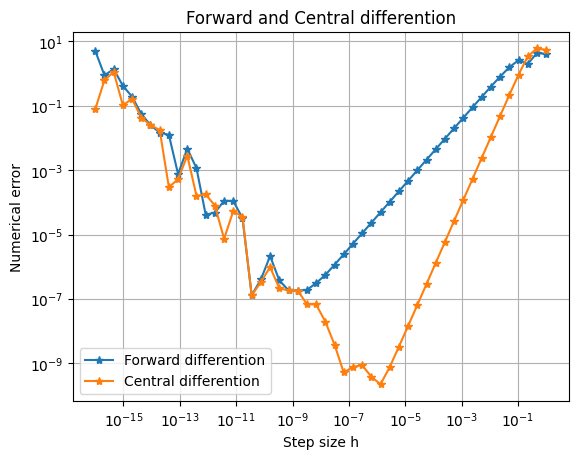

In [241]:
steps = np.logspace(-16, 0)

forward_difference = forward_difference(f, 1, steps)
central_difference = central_difference(f, 1, steps)
analytical = f_derived(1)


plt.plot(steps, np.abs(analytical - forward_difference), "-*", label="Forward differention")
plt.plot(steps, np.abs(analytical - central_difference), "-*", label="Central differention")
plt.grid()
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Step size h")
plt.ylabel("Numerical error")
plt.title("Forward and Central differention")
plt.show()